# Подготовка данных

## Изучение датасета

Для обучения НС будет использоваться датасет RTSD (Russian Traffic Sign Dataset)
Выведем количество знаков, количество изображений и распределение областей по классам.

In [45]:
import pandas as pd

path = 'dataset/rtsd-frames/'

dataset = pd.read_csv('full-gt.csv')
dataset.head()

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,2_1,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,2_1,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,2_1,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,2_1,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23,1


Взглянем на размеры изображений в датасете.

In [ ]:
from PIL import Image
from collections import Counter
import numpy as np
from os import listdir

filenames = listdir(path)
sizes = []
for name in filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

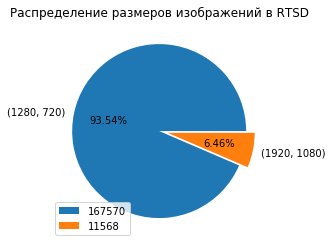

In [37]:
import matplotlib.pyplot as plt

plt.pie(sizes.values(), labels=sizes.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Распределение размеров изображений в RTSD')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Судя по всему, в датасете есть немало неразмеченных кадров. Проверим:

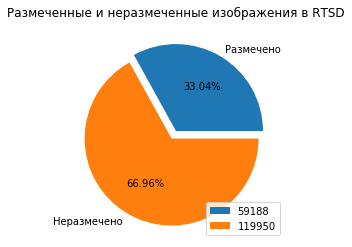

In [40]:
labeled_filenames = np.unique(dataset.filename)
labeled_length = len(labeled_filenames)
unlabeled_length = len(filenames)
files = { 'Размечено' : labeled_length, 'Неразмечено' : unlabeled_length - labeled_length }

plt.pie(files.values(), labels=files.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Размеченные и неразмеченные изображения в RTSD')
plt.legend(files.values(), loc='lower right')
plt.show()

Для обучения feature extractor'а такие изображения необходимы, так что это приемлимо.

Заодно проверим много ли неразмеченных изображений среди (1920, 1080). Есть подозрения, что их нет

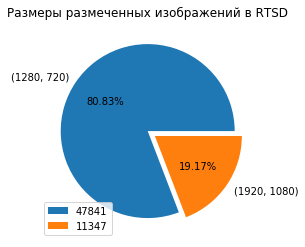

In [41]:
sizes = []
for name in labeled_filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

plt.pie(sizes.values(), labels=sizes.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Размеры размеченных изображений в RTSD')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Таким образом неразмеченных изображений (1920, 1080) чуть более двухста штук. 

Для обучения понадобятся лишь изображения (1280, 720), поэтому изменим размер всех остальных изображений из full-gt.csv к необходимому. Неразмеченные изображения (1920, 1080) затем просто удалим.

In [111]:
def resize_image(new_size, filename):
    img = Image.open(filename)
    size = img.size
    if size != new_size:
        img = img.resize(new_size, Image.ANTIALIAS)
        img.save(filename)
    return np.divide(size, new_size)


def resize_box(ratio, box):
    horizontal, vertical = ratio
    x, y, width, height = box
    return [int(x / horizontal),
            int(y / vertical),
            int(width / horizontal),
            int(height / vertical)]

path = 'dataset/rtsd-frames/'
dataset = pd.read_csv('full-gt.csv')
values = dataset.values
columns = dataset.columns
indices = dataset.index

filename = None
ratio = None
for i in indices:
    row = values[i]
    if row[0] != filename:
        filename = row[0]
        ratio = resize_image(
            (1280, 720),
            path + filename
        )
    row[1:5] = resize_box(ratio, row[1:5])
pd.DataFrame(values, columns=columns).to_csv('full-gt.csv', index=False)

In [112]:
import os

filenames = listdir(path)
for file in filenames:
    if Image.open(path + file).size == (1920, 1080):
        os.remove(path + file)

На всякий случай проверим получилось ли:

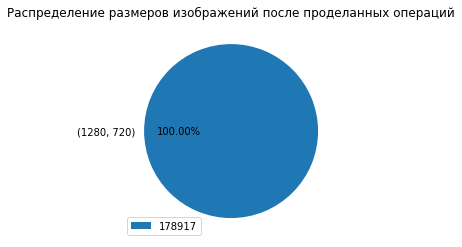

In [113]:
filenames = listdir(path)

sizes = []
for name in filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

plt.pie(sizes.values(), labels=sizes.keys(), autopct='%1.2f%%')
plt.title('Распределение размеров изображений после проделанных операций')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Так же стоит взглянуть на распределение по классам

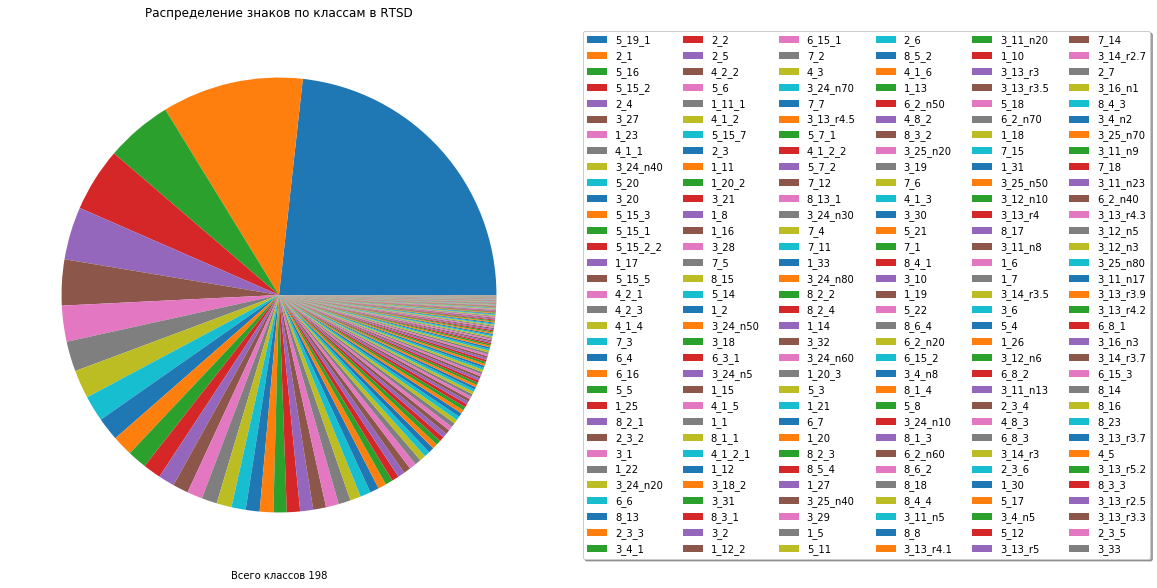

In [97]:
dataset = pd.read_csv('full-gt.csv')
classes = Counter(dataset.sign_class)
sorted_indices = np.argsort(list(classes.values()))[::-1]

plt.figure(figsize=(10,10))
plt.pie(np.take(list(classes.values()), sorted_indices),
        labels=None)
plt.title('Распределение знаков по классам в RTSD')
plt.legend(np.take(list(classes.keys()), sorted_indices),
           bbox_to_anchor=(1.05,0.5), loc="center left", ncol=6, fancybox=True, shadow=True)
plt.xlabel('Всего классов {}'.format(len(sorted_indices)))
plt.show()

Многие классы, насколько я понимаю, разбиты на группы. Например 3_25_n80 и 3_25_n40 - знаки ограничения скорости для 80 и 40 соответственно. Необходимо решить, как воспринимать эти знаки

Из векторов, содержащих информацию о наличии класса на изображении соберем матрицу, которую и будем использовать для обучения. Изображения, не содержащие знаки, будут иметь пометку в колонке background.

In [139]:
filenames = listdir(path)
dataset = pd.read_csv('full-gt.csv')[['filename', 'sign_class']]
classes = np.unique(dataset.sign_class)
groups = dataset.groupby('filename')['sign_class'].apply(list)
result = pd.DataFrame(filenames, columns=['filename'])

In [153]:
for name in classes:
    result[name] = 0
result['background'] = 0
for i in result.index:
    filename = filenames[i]
    if filename in groups.keys():
        for name in groups[filename]:
            result.at[i, name] = 1
    else:
        result.at[i, 'background'] = 1
result.to_csv('full.csv', index=False)

Скорее всего, после обучения на таких данных НС просто будет выдавать 0 в любом случае. Поэтому нужно уравнять ошибку с помощью весовых коэффициентов

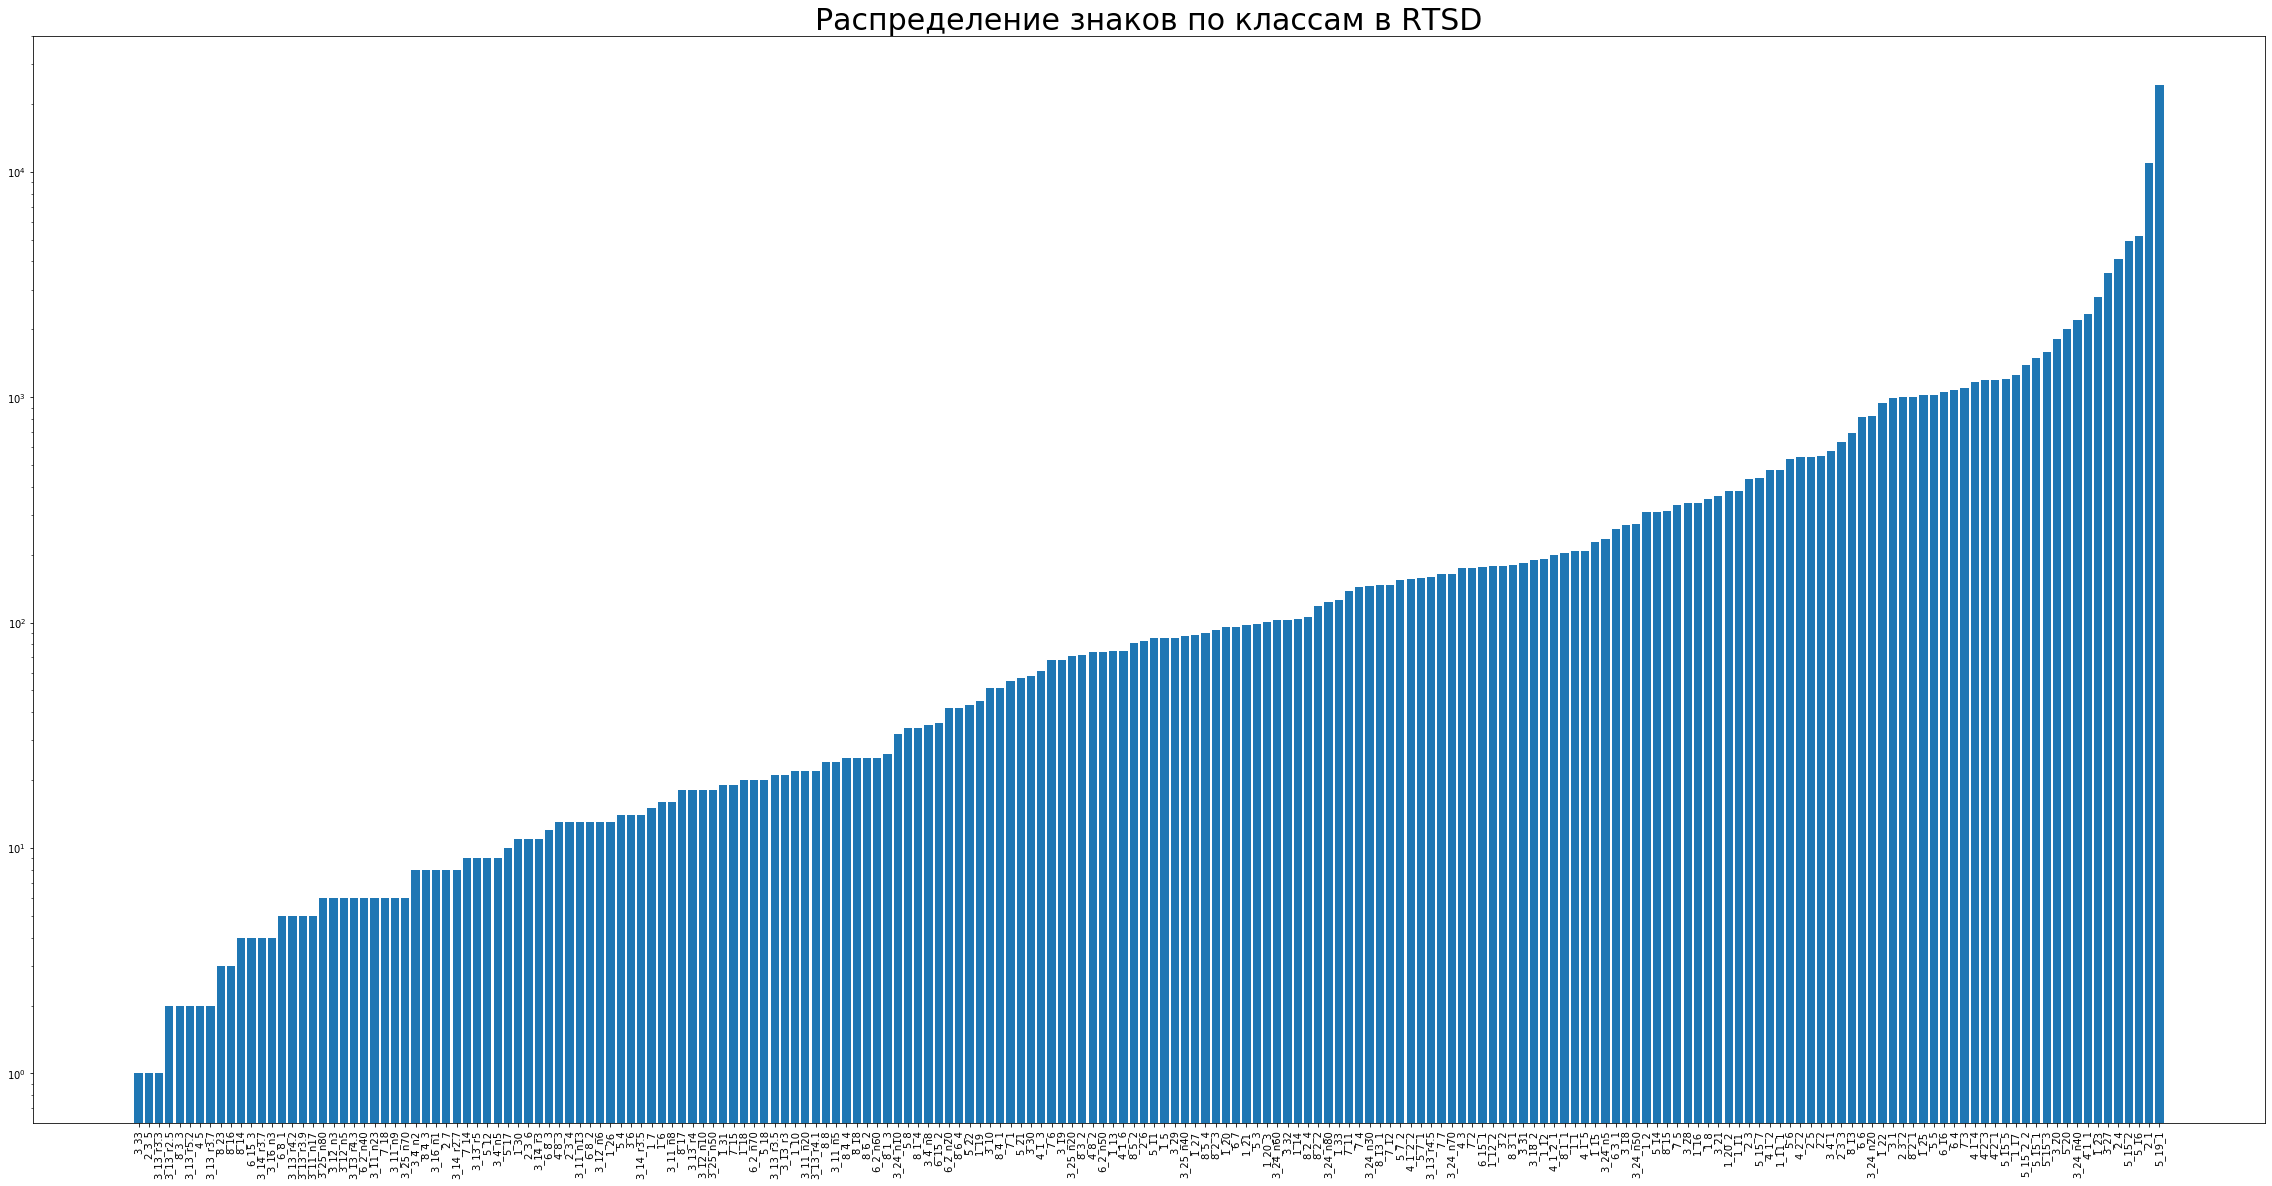

In [197]:
sorted_indices = np.argsort(list(classes.values()))
plt.figure(figsize=(40,20))
plt.bar(np.arange(len(sorted_indices)), np.take(list(classes.values()), sorted_indices),
        tick_label = np.take(list(classes.keys()), sorted_indices))
plt.title('Распределение знаков по классам в RTSD', size=30)
plt.xticks(rotation=90)
plt.yscale('log')
plt.savefig('classes.png')

## Классификатор
Основная идея - обучить классификатор на изображениях 64 на 64 и затем использовать его веса для свертки изображений больших размеров.

Для начала вырежем все gt box'ы и добавим к ним изображения заднего фона.

В датасете огромное количество знаков меньше чем 64 на 64, такие знаки мы, вместо того чтобы растягивать, будем вырезать вместе с фоном и обучаться на них. Проблема в том, что вместе с фоном на изображение могут попасть и другие знаки.
Решать ее будем так - отсортируем центры всех знаков на изображении по горизонтали и найдем те, которые досточно близки друг другу, затем отсортируем центры по вертикали и окончательно сгруппируем знаки. Верхний и нижний знаки таких групп мы будем вырезать смещая области вверх и вниз соответственно, остальные - вырезать и растягивать.

In [115]:
from sources.anchor_boxes import upleft_to_center, center_to_corners
from itertools import dropwhile, takewhile
import pandas as pd
import numpy as np
from PIL import Image


def get_stacked(array, distance):
    if len(array) == 1:
        return [[0]]
    sorted_indices = np.argsort(array)
    sorted_array = array[sorted_indices]
    chained_distances = [sorted_array[i + 1] - sorted_array[i] for i in range(len(sorted_array) -1)]
    pivots = []
    for i in range(len(chained_distances)):
        if chained_distances[i] > distance:
            pivots.append(i)
    groups = []
    prev = 0
    for i in pivots:
        groups.append(sorted_indices[prev:i + 1])
        prev = i + 1
    groups.append(sorted_indices[prev:])
    return groups


def validate_gt_boxes(boxes, size, fault):
    boxes = list(map(upleft_to_center, boxes))
    big_boxes_indices = np.argwhere([not (box[2] < size and box[3] < size) for box in boxes]).ravel()
    small_boxes_indices = np.argwhere([box[2] < size and box[3] < size for box in boxes]).ravel()
    
    result = np.take(boxes, big_boxes_indices, axis=0).tolist()
    result_indices = big_boxes_indices.tolist()
    if not len(small_boxes_indices):
        return list(map(center_to_corners, result)), result_indices
    
    min_distance = size * (1 - fault)
    small_boxes = np.take(boxes, small_boxes_indices, axis=0)
    stacked = get_stacked(small_boxes[:, 0], min_distance)
    for stack in stacked:
        tmp_indices = np.take(small_boxes_indices, stack)
        stacked_boxes = small_boxes[stack]
        grouped = get_stacked(stacked_boxes[:, 1], min_distance)
        for group in grouped:
            result_indices.extend(np.take(tmp_indices, group))
            grouped_boxes = stacked_boxes[group]
            if len(grouped_boxes) == 1:
                grouped_boxes[0][2] = size
                grouped_boxes[0][3] = size
                result.append(grouped_boxes[0])
                continue
            top_box = grouped_boxes[0]
            if grouped_boxes[1][0] > top_box[0]:
                top_box[0] -= min_distance // 2 - top_box[2] // 2
            else:
                top_box[0] += min_distance // 2 - top_box[2] // 2
            top_box[1] -= min_distance // 2 - top_box[3] // 2
            top_box[2] = size
            top_box[3] = size
            bottom_box = grouped_boxes[-1]
            if grouped_boxes[-2][0] > top_box[0]:
                bottom_box[0] -= min_distance // 2 - bottom_box[2] // 2
            else:
                bottom_box[0] += min_distance // 2 - bottom_box[2] // 2
            bottom_box[1] += min_distance // 2 - bottom_box[3] // 2
            bottom_box[2] = size
            bottom_box[3] = size
            result.extend(grouped_boxes)
    return list(map(center_to_corners, result)), result_indices


def validate_bounds(boxes, image_size):
    width, height = image_size
    result = []
    for box in boxes:
        x0, y0, x1, y1 = box
        assert abs(x1 - x0) <= width and abs(y1 - y0) <= height
        if x0 < 0:
            x1 += 0 - x0
            x0 = 0
        elif x1 > width:
            x0 -= x1 - width
            x1 = width
        if y0 < 0:
            y1 += 0 - y0
            y0 = 0
        elif y1 > height:
            y0 -= y1 - height
            y1 = height
        result.append([x0, y0, x1, y1])
    return result


def name_generator(init=0, numbers=7, image_format='.jpg'):
    index = init
    while True:
        yield str(index).zfill(numbers) + image_format
        index += 1

In [138]:
path_from = 'dataset/rtsd-frames/'
path_to = 'dataset/pool/'

dataset = pd.read_csv('processed.csv')
grouped = dataset.groupby('filename')
gen = name_generator()
names = []
classes = []
for name, group in grouped:
    img = Image.open(path_from + name)
    boxes = group[['x_from', 'y_from', 'width', 'height']].values
    boxes, indices = validate_gt_boxes(boxes, 64, 0.1)
    boxes = validate_bounds(boxes, (1280, 720))
    for box in boxes:
        fname = next(gen)
        names.append(fname)
        img.crop(box).save(path_to + fname)
    classes.extend(np.take(group.sign_class, indices))
dataset.filename = names
dataset.sign_class = classes
dataset.drop(columns=['x_from', 'y_from', 'width', 'height', 'sign_id'], inplace=True)
dataset.to_csv('dataset/dataset.csv', index=False)

Теперь объединим классы похожих знаков, но различающихся по тексту

In [118]:
dataset = pd.read_csv('dataset/dataset.csv')
classes = []
for cls in dataset['sign_class']:
    if '3_24_n' in cls:
        cls = '3_24'
    elif '3_25_n' in cls:
        cls = '3_25'
    elif '6_2_n' in cls:
        cls = '6_2'
    elif '3_12_n' in cls:
        cls = '3_12'
    elif '3_13_r' in cls:
        cls = '3_13'
    elif '3_11_n' in cls:
        cls = '3_11'
    elif '3_14_r' in cls:
        cls = '3_14'
    elif '3_4_n' in cls:
        cls = '3_4'
    elif '3_16_n' in cls:
        cls = '3_16'
    classes.append(cls)
dataset['sign_class'] = classes
dataset.to_csv('dataset/dataset.csv', index=False)

Во ремя обучения мы будем использовать генераторы данных Keras, которые умеют приводить изображения к определенному размеру. Поэтому все изображения, которые мы будем изменять по размеру (т.е. изображения без фона или изображения, где не получилось вырезать фон), стоит пометить как 64 на 64

In [210]:
path = 'dataset/pool/'

dataset = pd.read_csv('dataset.csv')
for i, row in dataset.iterrows():
    name = row['filename']
    img = Image.open(path + name)
    width, height = img.size
    if width == row['width'] or height == row['width']:
        dataset.at[i, 'width'] = 64
        dataset.at[i, 'height'] = 64
dataset.to_csv('dataset.csv', index=False)

Теперь, когда все изображения вырезаны, добавим к ним background. Будем брать 64 на 64

In [124]:
from random import randrange
from os import listdir
import pandas as pd
import numpy as np
from PIL import Image

def get_rnd_square(side, image_size):
    width, height = image_size
    return randrange(0, width - side), randrange(0, height - side)

In [139]:
path_from = 'dataset/rtsd-frames/'
path_to = 'dataset/pool/'

dataset = pd.read_csv('full-gt.csv')
gen = name_generator(200000)
filenames = set(listdir(path_from))
dataset_filenames = set(dataset.filename)
filenames -= dataset_filenames
filenames = list(filenames)[:50000]
names = []
for name in filenames:
    img = Image.open(path_from + name)
    left, top = get_rnd_square(64, (1280, 720))
    right = left + 64
    bottom = top + 64
    name = next(gen)
    names.append(name)
    img = img.crop((left, top, right, bottom))
    img.save(path_to + name)
background = pd.DataFrame()
background['filename'] = names
background['sign_class'] = 'not_sign'
background.to_csv('background.csv', index=False)

Склеим датафреймы

In [140]:
dataset = pd.read_csv('dataset/dataset.csv')
background = pd.read_csv('background.csv')
dataset.append(background, ignore_index=True).to_csv('dataset/dataset.csv', index=False)

Распределение классов после добавления фона

In [ ]:
import os

path_to = 'dataset/pool/'

filenames = dataset.filename[150000:]
for name in filenames:
    os.remove(path_to + name)
dataset = dataset[:150000]
dataset.to_csv('dataset.csv', index=False)

In [212]:
from collections import Counter
import pandas as pd

dataset = pd.read_csv('dataset.csv')
classes = Counter(dataset.sign_class)

print('Not sign: {}'.format(classes['not_sign']))
print('Total: {}'.format(sum(classes.values())))

Not sign: 45642
Total: 150000


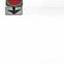

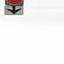

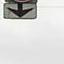

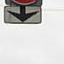

In [217]:
def show_class_sample(filename, path_to_images, sclass):
    for i, row in pd.read_csv(filename).iterrows():
        if row.sign_class == sclass:
            img = Image.open(path_to_images + row.filename)
            display(img)

show_class_sample('dataset.csv', 'dataset/pool/', '8_14')

Некоторых знаков в датасете едва ли набирается 20 штук. Если при обучении выравнивать веса (а в нашем случае это, пожалуй, единственный вариант), то ответы на таких знаках будут очень сильно влиять на обучение сети. Причем, как правильные, так и неправильные.

In [221]:
from collections import Counter
import os

path = 'dataset/pool/'
dataset = pd.read_csv('dataset.csv')
classes = Counter(dataset.sign_class)

del_classes = []
for key, value in classes.items():
    if value < 42:
        del_classes.append(key)

del_indices = []
del_files = []
for i, row in dataset.iterrows():
    if row.sign_class in del_classes:
        del_indices.append(i)
        del_files.append(row.filename)

dataset.drop(del_indices, inplace=True)
dataset.to_csv('dataset.csv', index=False)

for file in del_files:
    os.remove(path + file)

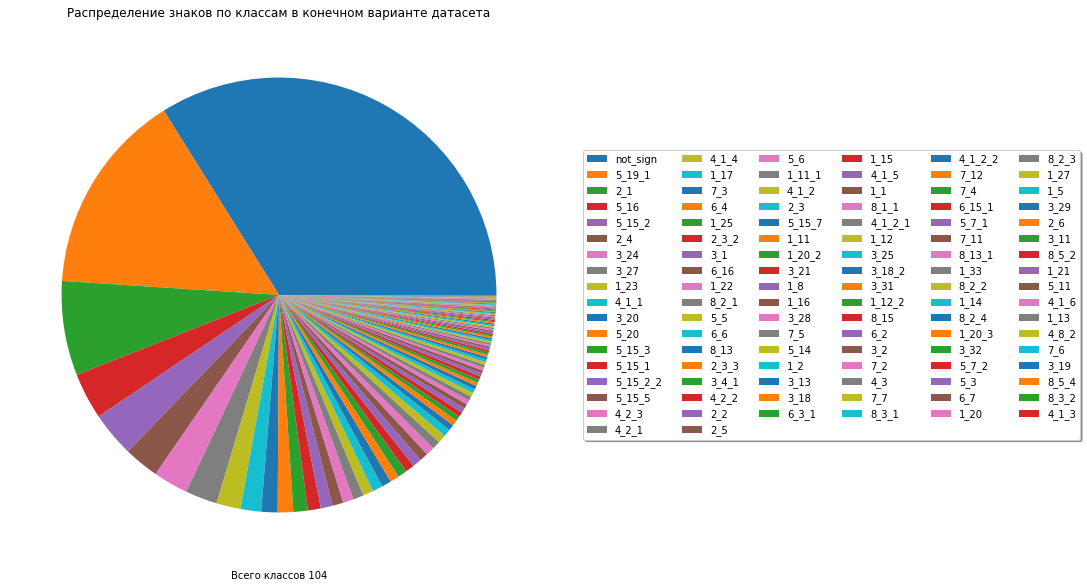

In [141]:
dataset = pd.read_csv('dataset/dataset.csv')
classes = Counter(dataset.sign_class)
sorted_indices = np.argsort(list(classes.values()))[::-1]

plt.figure(figsize=(10,10))
plt.pie(np.take(list(classes.values()), sorted_indices),
        labels=None)
plt.title('Распределение знаков по классам в конечном варианте датасета')
plt.legend(np.take(list(classes.keys()), sorted_indices),
           bbox_to_anchor=(1.05,0.5), loc="center left", ncol=6, fancybox=True, shadow=True)
plt.xlabel('Всего классов {}'.format(len(sorted_indices)))
plt.show()

## Разбиение датасета на выборки для обучения, тестирования и валидации

Не смотря на то, что Keras умеет делать все это сам, разбить вручную все-таки проще.
Будем использовать библиотеку sklearn

In [128]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil as sh

def split_dataset(filename, train_filename, test_filename, size_ratio=0.25):
    dataset = pd.read_csv(filename)
    x = dataset.filename
    y = dataset.drop('filename', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=size_ratio, random_state=42
    )
    train = pd.concat([x_train, y_train], axis=1)
    train.to_csv(train_filename, index=False)
    test = pd.concat([x_test, y_test], axis=1)
    test.to_csv(test_filename, index=False)

def name_generator(init=0, numbers=7, image_format='.jpg'):
    index = init
    while True:
        yield str(index).zfill(numbers) + image_format
        index += 1

def move_with_csv(filename, path_from, path_to):
    dataset = pd.read_csv(filename)
    gen = name_generator()
    names = []
    for i, row in dataset.iterrows():
        name = next(gen)
        sh.copyfile(path_from + row.filename, path_to + name)
        names.append(name)
    dataset.filename = names
    dataset.to_csv(filename, index=False)

In [142]:
split_dataset('dataset/dataset.csv',
              'dataset/train.csv',
              'dataset/test.csv')
split_dataset('dataset/train.csv',
              'dataset/train.csv',
              'dataset/validation.csv')

In [143]:
move_with_csv('dataset/train.csv',
              'dataset/pool/',
              'dataset/train/')
move_with_csv('dataset/test.csv',
              'dataset/pool/',
              'dataset/test/')
move_with_csv('dataset/validation.csv',
              'dataset/pool/',
              'dataset/validation/')

И заодно в очередной раз посчитаем количество классов. Позже это пригодится, когда нужно будет уравнивать веса.

In [144]:
dataset = pd.read_csv('dataset/dataset.csv')
classes = Counter(dataset.sign_class)
indices = np.argsort(list(classes.values()))
counts = pd.DataFrame()
counts['class'] = np.take(list(classes.keys()), indices)
counts['count'] = np.take(list(classes.values()), indices)
counts.to_csv('dataset/counts.csv', index=False)

## Распределение изображений по размерам

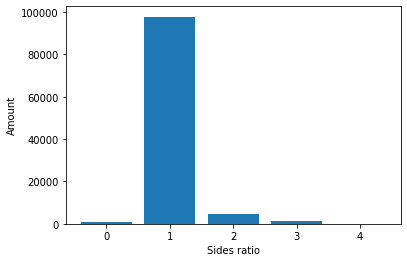

In [3]:
import pandas as pd
import numpy as np
import collections as cs
import matplotlib.pyplot as plt

dataset = pd.read_csv('full-gt.csv')
dataset['ratio'] = np.round(dataset['width'] / dataset['height'])
ratios = cs.Counter(dataset['ratio'])
plt.bar(list(ratios.keys()), list(ratios.values()))
plt.xlabel('Sides ratio')
plt.ylabel('Amount')
plt.show()

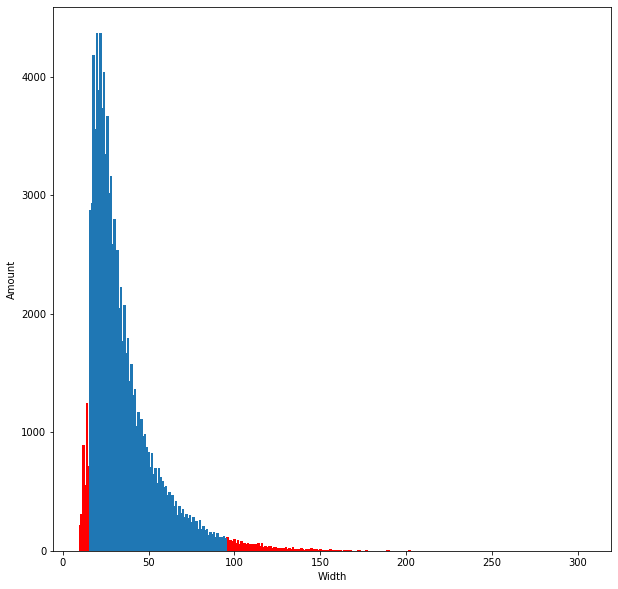

In [5]:
from itertools import takewhile, dropwhile

widths = dataset['width'].values
widths = np.sort(widths)
taken_w = list(dropwhile(lambda x: x < 16, widths))
taken_w = list(takewhile(lambda x: x < 96, taken_w))
taken_w = cs.Counter(taken_w)
all_w = cs.Counter(widths)
plt.figure(figsize=(10, 10))
plt.bar(list(all_w.keys()), list(all_w.values()), width=1.5, color='r')
plt.bar(list(taken_w.keys()), list(taken_w.values()), width=1.5)
plt.xlabel('Width')
plt.ylabel('Amount')
plt.show()

In [6]:
def compute_precentage(left_tr, right_tr, arr, label):
    sorted_arr = np.sort(arr)
    taken = list(dropwhile(lambda x: x < left_tr, sorted_arr))
    taken = list(takewhile(lambda x: x <= right_tr, taken))
    
    fig, axs = plt.subplots(2, figsize=(10, 10))
    fig.suptitle(
        'Выбранные данные составляют {}%'.format(round(float(len(taken)) / len(sorted_arr) * 100, 2))
    )
    d_all = cs.Counter(sorted_arr)
    d_taken = cs.Counter(taken)
    axs[0].bar(list(d_all.keys()), list(d_all.values()), width=1.5, color='r')
    axs[0].bar(list(d_taken.keys()), list(d_taken.values()), width=1.5)
    axs[0].set_xlabel(label)
    axs[0].set_ylabel('Количество')
    axs[0].legend(['Левая граница: ' + str(left_tr),
                   'Правая граница: ' + str(right_tr)],
                  loc='upper right', handlelength=0)
    axs[1].pie([len(sorted_arr) - len(taken), len(taken)], labels=['Под удаление', 'Выбранное'], autopct='%1.0f%%')
    plt.show()

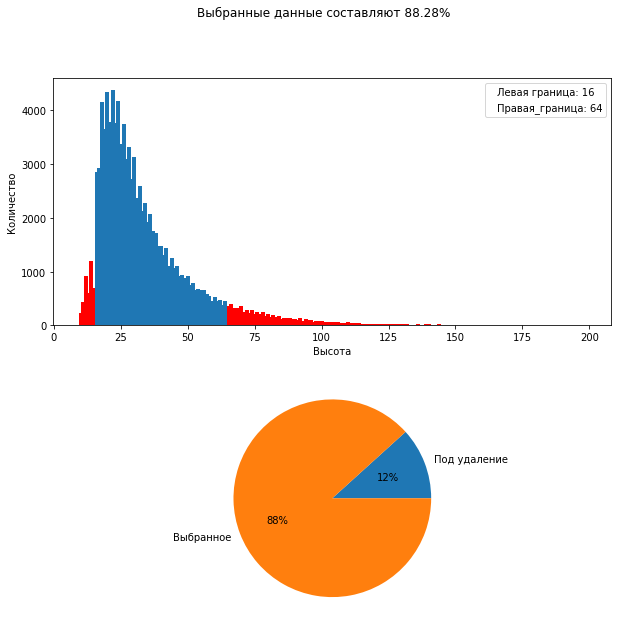

In [9]:
compute_precentage(16, 64, dataset['height'].values, label='Высота')

## Финальная подготовка датасета
Этот скрипт позволяет получить просеянный и разбитый на части датасет

In [ ]:
!mkdir -p dataset/pool/
!mkdir dataset/train/
!mkdir dataset/test/
!mkdir dataset/validation/

Уберем изображения ненужных размеров, а так же изображения, принадлежащие классам, количество которых в сете меньше 60. Предварительно объединим некоторые классы знаков

In [120]:
dataset = pd.read_csv('full-gt.csv')
classes = []
for cls in dataset['sign_class']:
    if '3_24_n' in cls:
        cls = '3_24'
    elif '3_25_n' in cls:
        cls = '3_25'
    elif '6_2_n' in cls:
        cls = '6_2'
    elif '3_12_n' in cls:
        cls = '3_12'
    elif '3_13_r' in cls:
        cls = '3_13'
    elif '3_11_n' in cls:
        cls = '3_11'
    elif '3_14_r' in cls:
        cls = '3_14'
    elif '3_4_n' in cls:
        cls = '3_4'
    elif '3_16_n' in cls:
        cls = '3_16'
    classes.append(cls)
dataset['sign_class'] = classes
dataset.to_csv('processed.csv', index=False)

In [121]:
dataset = pd.read_csv('processed.csv')
classes = cs.Counter(dataset['sign_class'].values)

del_classes = []
for key, value in classes.items():
    if value < 60:
        del_classes.append(key)

del_indices = []
for i, row in dataset.iterrows():
    if row['height'] < 16 or row['height'] > 96 or row['sign_class'] in del_classes:
        del_indices.append(i)
        
dataset.drop(del_indices, inplace=True)
dataset.to_csv('processed.csv', index=False)